In [1]:
import osmnx as ox
import geopandas as gpd
import pyproj
import csv

from shapely.geometry import Point
ox.settings.use_cache=True
ox.settings.log_console=True

In [2]:
pyproj.datadir.set_data_dir('C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj')
pyproj.datadir.get_data_dir()

'C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj'

### Demonstration
We want to find the nearest edge to the centroids of all polygons representing the PA fields in the north-east region of Costa Rica.

First we demonstrate the process using a single point near Pital

In [57]:
%%time
# lat (y) lon(x) points

xlon = -84.278967
ylat = 10.476319
point = ylat, xlon # center of PA field near Pital

G = ox.graph_from_point(point, network_type='all_private', dist=1000)

# project the graph (and point) to a meter projection
Gp = ox.project_graph(G)

point_geom_proj, crs = ox.projection.project_geometry(Point(reversed(point)), to_crs=Gp.graph['crs'])
x, y = point_geom_proj.x, point_geom_proj.y


CPU times: total: 219 ms
Wall time: 568 ms


In [58]:
%%time
# find nearest edge as (u, v, key) and distance to it
test, dist = ox.nearest_nodes(Gp, Y=y, X=x, return_dist=True)

CPU times: total: 0 ns
Wall time: 53.1 ms


In [59]:
#convert u,v,key to list
unique_edges = [test]

We also get the distance from the centroid to the edge (street) in meters. This will be used to penalize for transportation within the field

In [7]:
print(round(dist,2), 'meters')

274.95 meters


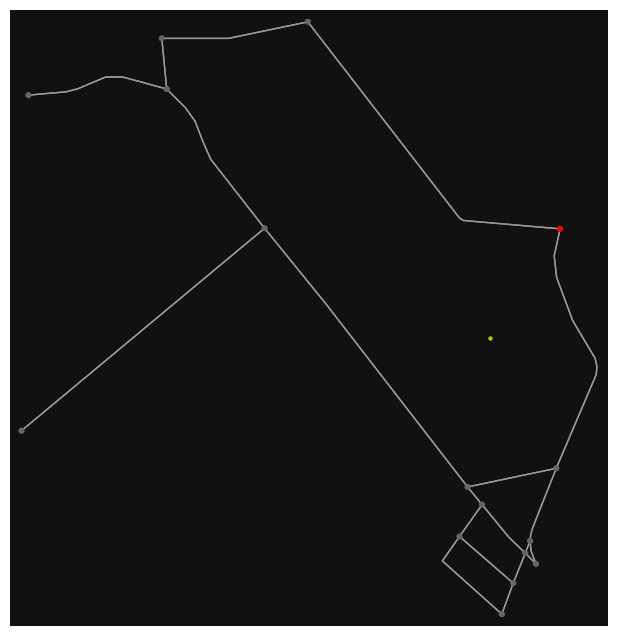

In [8]:
# In yellow is the centoid, in red we see the nearest steet to the centroid
ec = ['r' if e in unique_edges else '#666666' for e in G.nodes]
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False)
fig, ax = ox.plot_graph(G, node_color=ec, edge_linewidth=1, node_size=20, show=False)
ax = ax.scatter(xlon,ylat,c='y', s=5, zorder=-1)

### Now we perform the same calculations with all pineapple fields centroids 

In [3]:
## path to PA fields and network
pal = r'C:\Users\isaldiviagonzatti\Downloads/gitFiles/MScThesisCode/FLP/output/ northPAL.gpkg'
networkFile = r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/strongNetwork.gpkg'

In [4]:
palPoint = gpd.read_file(pal)

In [5]:
#define lon, lat points
xlon=palPoint['geometry'].x
ylat=palPoint['geometry'].y

In [6]:
#load road network
gdf_nodes = gpd.read_file(networkFile, layer='nodes').set_index('osmid')
gdf_edges = gpd.read_file(networkFile, layer='edges').set_index(['u', 'v', 'key'])
assert gdf_nodes.index.is_unique and gdf_edges.index.is_unique

In [7]:
# convert the node/edge GeoDataFrames to a MultiDiGraph
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs)

In [8]:
%%time
G_proj = ox.project_graph(G)

CPU times: total: 9.5 s
Wall time: 11.6 s


In [9]:
# project graph and points to same CRS
geom = gpd.points_from_xy(xlon, ylat)
gdf = gpd.GeoDataFrame(palPoint, crs='epsg:4326').to_crs(G_proj.graph['crs'])

In [10]:
%%time
# calculate nearest edge to each point
nePAL = ox.nearest_nodes(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y,  return_dist=True)
#nePAL = ox.nearest_edges(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y, interpolate=10, return_dist=True)

CPU times: total: 1.08 s
Wall time: 1.54 s


In [11]:
edgesPAL = nePAL[0]
distPAL = nePAL[1]

Let's see how far is the farest centroid from its corresponding street:

In [12]:
print(max(distPAL), 'meters')

4215.325786369086 meters


In [13]:
unique_edges = set(edgesPAL)

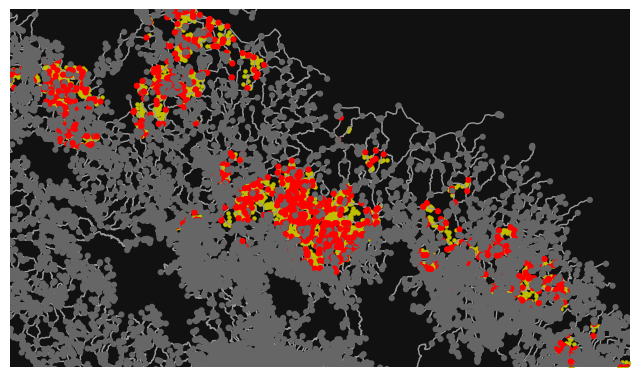

In [14]:
ec = ['r' if e in unique_edges else '#666666' for e in G.nodes]
fig, ax = ox.plot_graph(G, node_color=ec, edge_linewidth=1, node_size=20, show=False, bbox=(11.04681261,10.09956058,-83.40407159,-85.07389766))
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False, bbox=(11.04681261,10.09956058,-83.40407159,-85.07389766))
ax = ax.scatter(xlon, ylat, c='y', s=5, zorder=-1)

Let's look at the area from the demonstration

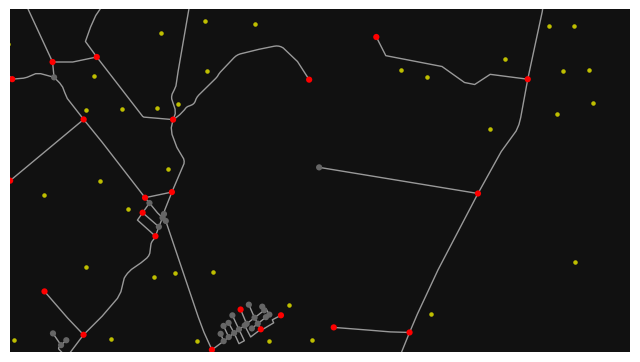

In [15]:
ec = ['r' if e in unique_edges else '#666666' for e in G.nodes]
fig, ax = ox.plot_graph(G, node_color=ec, edge_linewidth=1, node_size=20, show=False, bbox=(10.4854,10.4637,-84.2482,-84.2881))
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False, bbox=(10.4854,10.4637,-84.2482,-84.2881))
ax = ax.scatter(xlon, ylat, c='y', s=5, zorder=-1)

#### We save the tuple with osmid and distances to a csv

In [16]:
with open(r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/nearestNodePAL.csv', 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    for tup in nePAL:
        writer.writerow(tup)